## Transfer Learning
Author: Aakash Kaku, Lee Tanenbaum

Storing knowledge gained while solving one problem and applying it to a different but related problem. Rather than train our own networks, it is common whenever possible to start with a pretrained network for a similar task and then retraining for our task.


### Why?
This has 2 advantages. First, it allows us to learn from a larger repository of data, even though part of it wasnt directly related to our task.


Second, it grants us huge reduction in training times. Rather than just using both datasets, we can also use all the computation put in to learn the first, usually much larger dataset. In this way we can train a very smart general purpose model once, and then use copies of it to solve many smaller related tasks with very little computational cost.


### How?
We start with a pre trained model, but the model had a different task than ours. Therefore, we usually need to chop off the last layer of the network and replace it with our output layer to solve our task.


Now here's the tradeoff. 


Do we just retrain that last layer? 


Do we retrain the whole network and maybe lose the learning from pre training? 


Do we retrain the whole network but use a small learning rate for all but the last layer? 


Do we retrain the whole network but box the pre trained layers into little hypercubes, enforcing that their parameters cannot change more than some small delta from their initial value?


Do we first train the last layer so we utilize our pretrained network to build a good last layer without throwing off our pretrained network, then retrain the whole network?


Those all sound like reasonable approaches and are all done, try different approaches and see what works for your problem. Usually the last option of first retraining the last layer, then retraining the whole network works best for most applications


### This lab:
This lab below this point was taken from a very clear pytorch tutorial online, http://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html and we're gonna work through it.

In [1]:
%matplotlib inline


Transfer Learning tutorial
==========================
**Author**: `Sasank Chilamkurthy <https://chsasank.github.io>`_

In this tutorial, you will learn how to train your network using
transfer learning. You can read more about the transfer learning at `cs231n
notes <http://cs231n.github.io/transfer-learning/>`__

Quoting these notes,

    In practice, very few people train an entire Convolutional Network
    from scratch (with random initialization), because it is relatively
    rare to have a dataset of sufficient size. Instead, it is common to
    pretrain a ConvNet on a very large dataset (e.g. ImageNet, which
    contains 1.2 million images with 1000 categories), and then use the
    ConvNet either as an initialization or a fixed feature extractor for
    the task of interest.

These two major transfer learning scenarios look as follows:

-  **Finetuning the convnet**: Instead of random initializaion, we
   initialize the network with a pretrained network, like the one that is
   trained on imagenet 1000 dataset. Rest of the training looks as
   usual.
-  **ConvNet as fixed feature extractor**: Here, we will freeze the weights
   for all of the network except that of the final fully connected
   layer. This last fully connected layer is replaced with a new one
   with random weights and only this layer is trained.




In [2]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

Load Data
---------

We will use torchvision and torch.utils.data packages for loading the
data.

The problem we're going to solve today is to train a model to classify
**ants** and **bees**. We have about 120 training images each for ants and bees.
There are 75 validation images for each class. Usually, this is a very
small dataset to generalize upon, if trained from scratch. Since we
are using transfer learning, we should be able to generalize reasonably
well.

This dataset is a very small subset of imagenet.

.. Note ::
   Download the data from
   `here <https://download.pytorch.org/tutorial/hymenoptera_data.zip>`_
   and extract it to the current directory.



In [7]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

Visualize a few images
^^^^^^^^^^^^^^^^^^^^^^
Let's visualize a few training images so as to understand the data
augmentations.



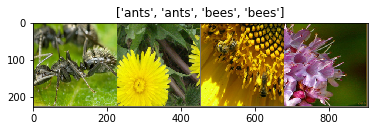

In [8]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

Training the model
------------------

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.



In [33]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dataloaders[phase]:
                # get the inputs
                inputs, labels = data

                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
#                 print(torch.sum(preds == labels))
                
                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size()[0]
                running_corrects += torch.sum(preds == labels).item()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            scheduler.step()

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

Visualizing the model predictions
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Generic function to display predictions for a few images




In [48]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    for i, data in enumerate(dataloaders['val']):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}, true: {}'.format(class_names[preds[j]],class_names[labels[j]]))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                model.train(mode=was_training)
                return
    model.train(mode=was_training)

Not using the pre-trained network the convnet
----------------------

Load a pretrained model and reset final fully connected layer.




In [49]:
model_ft = models.resnet18(pretrained=False)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.0005)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.1)

Train and evaluate
^^^^^^^^^^^^^^^^^^

It should take around 15-25 min on CPU. On GPU though, it takes less than a
minute.




In [50]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=20)

Epoch 0/19
----------
train Loss: 0.8951 Acc: 0.5697
val Loss: 1.3599 Acc: 0.5294

Epoch 1/19
----------
train Loss: 0.6986 Acc: 0.5779
val Loss: 0.6358 Acc: 0.6536

Epoch 2/19
----------
train Loss: 0.6018 Acc: 0.6762
val Loss: 0.6248 Acc: 0.6471

Epoch 3/19
----------
train Loss: 0.6238 Acc: 0.6557
val Loss: 0.6158 Acc: 0.6797

Epoch 4/19
----------
train Loss: 0.6091 Acc: 0.6475
val Loss: 0.6266 Acc: 0.6863

Epoch 5/19
----------
train Loss: 0.6011 Acc: 0.6926
val Loss: 0.6087 Acc: 0.6797

Epoch 6/19
----------
train Loss: 0.5783 Acc: 0.6967
val Loss: 0.6032 Acc: 0.6797

Epoch 7/19
----------
train Loss: 0.6232 Acc: 0.6557
val Loss: 0.6150 Acc: 0.6928

Epoch 8/19
----------
train Loss: 0.5880 Acc: 0.6926
val Loss: 0.6084 Acc: 0.7124

Epoch 9/19
----------
train Loss: 0.6150 Acc: 0.6557
val Loss: 0.6173 Acc: 0.6797

Epoch 10/19
----------
train Loss: 0.6082 Acc: 0.6598
val Loss: 0.6253 Acc: 0.6797

Epoch 11/19
----------
train Loss: 0.6377 Acc: 0.6311
val Loss: 0.6089 Acc: 0.7059

Ep

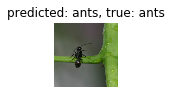

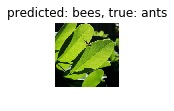

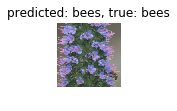

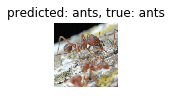

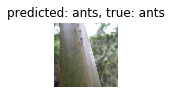

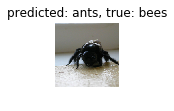

In [51]:
visualize_model(model_ft)

Finetuning the convnet
----------------------

Load a pretrained model and reset final fully connected layer.




In [52]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.0005)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.1)

Train and evaluate
^^^^^^^^^^^^^^^^^^

It should take around 15-25 min on CPU. On GPU though, it takes less than a
minute.




In [53]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=5)

Epoch 0/4
----------
train Loss: 0.8593 Acc: 0.6393
val Loss: 1.0385 Acc: 0.6209

Epoch 1/4
----------
train Loss: 0.6495 Acc: 0.6762
val Loss: 0.5895 Acc: 0.7582

Epoch 2/4
----------
train Loss: 0.5262 Acc: 0.7172
val Loss: 0.4415 Acc: 0.8170

Epoch 3/4
----------
train Loss: 0.5123 Acc: 0.7500
val Loss: 0.4064 Acc: 0.8170

Epoch 4/4
----------
train Loss: 0.4565 Acc: 0.8115
val Loss: 0.3964 Acc: 0.8431

Training complete in 0m 59s
Best val Acc: 0.843137


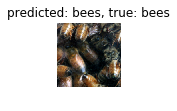

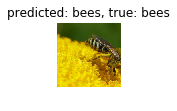

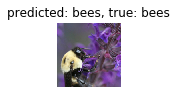

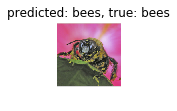

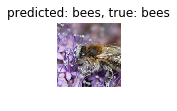

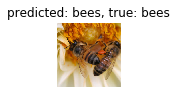

In [54]:
visualize_model(model_ft)

ConvNet as fixed feature extractor
----------------------------------

Here, we need to freeze all the network except the final layer. We need
to set ``requires_grad == False`` to freeze the parameters so that the
gradients are not computed in ``backward()``.

You can read more about this in the documentation
`here <http://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward>`__.




In [55]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer_conv = optim.Adam(model_conv.fc.parameters(), lr=0.0005)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=5, gamma=0.1)

Train and evaluate
^^^^^^^^^^^^^^^^^^

On CPU this will take about half the time compared to previous scenario.
This is expected as gradients don't need to be computed for most of the
network. However, forward does need to be computed.




In [56]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=5)

Epoch 0/4
----------
train Loss: 0.6493 Acc: 0.6311
val Loss: 0.4260 Acc: 0.8562

Epoch 1/4
----------
train Loss: 0.5459 Acc: 0.7500
val Loss: 0.3332 Acc: 0.9281

Epoch 2/4
----------
train Loss: 0.4790 Acc: 0.7582
val Loss: 0.3242 Acc: 0.9150

Epoch 3/4
----------
train Loss: 0.4744 Acc: 0.7787
val Loss: 0.3171 Acc: 0.9020

Epoch 4/4
----------
train Loss: 0.4605 Acc: 0.7828
val Loss: 0.3236 Acc: 0.9346

Training complete in 0m 41s
Best val Acc: 0.934641


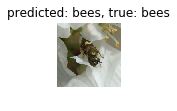

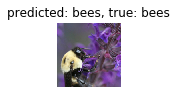

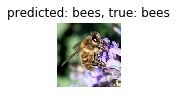

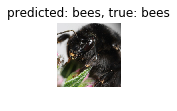

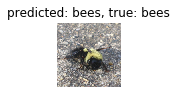

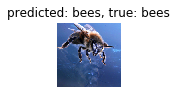

In [57]:
visualize_model(model_conv)

plt.ioff()
plt.show()